<a href="https://colab.research.google.com/github/albertchristian92/BBC-Text-Categorization/blob/main/Dicoding_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Pertama-tama set runtime setting to GPU pada google colabs agar dapat di run menggunakan GPU, sebab jika training menggunakan CPU akan consume time
#Runtime-> Change Runtime type
#Cek apakah sudah menggunakan GPU atau belum

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#Cek GPU apa yang digunakan
!nvidia-smi

Thu Jul 15 09:33:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    222MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
#Import Library yang dibutuhkan
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

#This code was tested with TensorFlow v2.4.1
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 2.5.0


Upload dataset ke google colabs:
Dataset yang saya gunakan:  https://www.kaggle.com/yufengdev/bbc-fulltext-and-category

In [4]:
#baca data dan tampilkan 5 sampel teratas pada dataset
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
# one-hot-encoding 
kategori = pd.get_dummies(df.category)
df_baru = pd.concat([df, kategori], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [6]:
#ubah nilai-nilai dari dataframe ke dalam tipe data numpy array 
news_text = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics', 'sport', 'tech']].values


In [7]:
#bagi dataset menjadi train dan test set
train_text,test_text,train_label,test_label=train_test_split(news_text,label,test_size=0.2)

In [8]:
max_kata = 1000
tokenizer = Tokenizer(num_words=max_kata, oov_token='x')
tokenizer.fit_on_texts(train_text) 
tokenizer.fit_on_texts(test_text)
 
sekuens_train = tokenizer.texts_to_sequences(train_text)
sekuens_test = tokenizer.texts_to_sequences(test_text)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(512, input_shape=(max_kata,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4, input_shape=(2,)),
    tf.keras.layers.Dense(128, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

AttributeError: ignored

In [10]:
#set batch size, epoch, and drop ratio
batch_size = 16
num_epochs = 30


In [11]:
history = model.fit(padded_train, train_label, epochs=num_epochs, 
                    validation_data=(padded_test, test_label), verbose=1, validation_split=0.1)

Epoch 1/30
51/51 [==============================] - 10s 142ms/step - loss: 1.6048 - accuracy: 0.2185 - val_loss: 1.6011 - val_accuracy: 0.3034
Epoch 2/30
51/51 [==============================] - 7s 133ms/step - loss: 1.4894 - accuracy: 0.3677 - val_loss: 1.4358 - val_accuracy: 0.3876
Epoch 3/30
51/51 [==============================] - 7s 133ms/step - loss: 1.2466 - accuracy: 0.4819 - val_loss: 1.0676 - val_accuracy: 0.5506
Epoch 4/30
51/51 [==============================] - 7s 133ms/step - loss: 0.9290 - accuracy: 0.6180 - val_loss: 0.8598 - val_accuracy: 0.6517
Epoch 5/30
51/51 [==============================] - 7s 134ms/step - loss: 0.6677 - accuracy: 0.7509 - val_loss: 0.8932 - val_accuracy: 0.7079
Epoch 6/30
51/51 [==============================] - 7s 134ms/step - loss: 0.5969 - accuracy: 0.7909 - val_loss: 0.8022 - val_accuracy: 0.6966
Epoch 7/30
51/51 [==============================] - 7s 134ms/step - loss: 0.4088 - accuracy: 0.8670 - val_loss: 0.7283 - val_accuracy: 0.7697
Epoch

In [13]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

Nilai Train loss : 0.0
Nilai Akurasi train : 0.0
Nilai Test Loss: 0.0
Nilai Akurasi Test : 0.0
Weights Saved


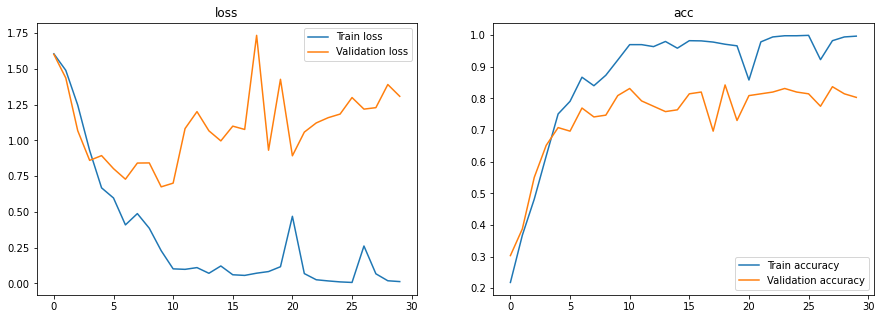

In [16]:

#Cetak grafik dan nilai train dan test

show_final_history(history)
train_score = model.evaluate(padded_train, verbose=0)
test_score = model.evaluate(test_label, verbose=0)
print("Nilai Train loss :",train_score[0])
print("Nilai Akurasi train :",train_score[1])
print("Nilai Test Loss:",test_score[0])
print("Nilai Akurasi Test :",test_score[1])

#save model   
model.save("model.h5")
print("Weights Saved")